# Optimal Sampling

Pull request [#36](https://github.com/keflavich/imf/pull/36) to ``imf`` adds support for _optimal sampling_ of mass functions as described in Section 2.2 of Kroupa et al. (2013). This notebook provides some example uses and highlights some of the potential pitfalls.

In [1]:
from imf import Salpeter,Kroupa,ChabrierLogNormal,ChabrierPowerLaw,KoenConvolvedPowerLaw
from imf import make_cluster
import numpy as np
import matplotlib.pyplot as plt
from time import perf_counter

In [2]:
# helper functions for plotting
def normalization(max_star,massfunc):
    return 1/massfunc.integrate(max_star,massfunc.mmax)[0]

def hist_props(stars,massfunc):
    edges = [stars[0]*1.01]
    for i in range(1,np.floor_divide(len(stars),10)):
        try:
            edge = (stars[10*i-1]+stars[10*i])/2
            edges.append(edge)
        except(IndexError):
            continue
    edges.append(massfunc.mmin)
    edges = np.array(edges)[::-1]
    dm = edges[1:]-edges[:-1]

    weights = np.ones(len(stars))
    for i in range(len(dm)):
        weights[np.logical_and(stars > edges[i],stars < edges[i+1])] *= 1/dm[i]
        
    return edges,weights

To use optimal sampling, enter it as input to the "sampling' keyword in "make_cluster":

In [3]:
opt_cl = make_cluster(1e3,'kroupa',sampling='optimal')
rand_cl = make_cluster(1e3,'kroupa',stop_criterion='nearest')

Total cluster mass is 999.986 (limit was 1000)
Total cluster mass is 999.483 (limit was 1000)


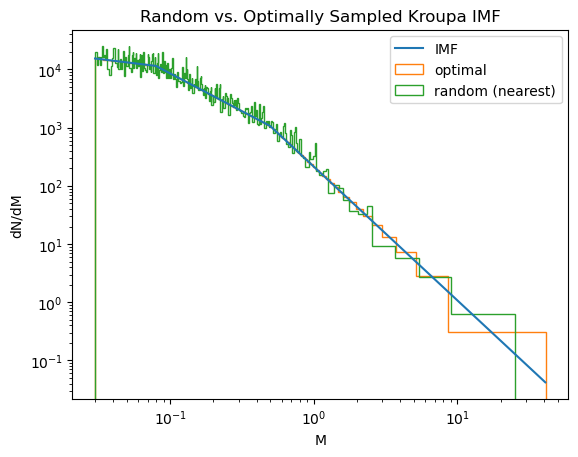

In [4]:
plt.figure()
massfunc = Kroupa()
k = normalization(opt_cl[0],massfunc)
plt.plot(opt_cl,k*massfunc(opt_cl),label='IMF')

edges,weights = hist_props(opt_cl,massfunc)
n,bins,patches = plt.hist(opt_cl,bins=edges,weights=weights,histtype='step',
                          label='optimal',zorder=-2)

rand_cl.sort()
rand_cl = rand_cl[::-1]
edges,weights = hist_props(rand_cl,massfunc)
n,bins,patches = plt.hist(rand_cl,bins=edges,weights=weights,histtype='step',
                          label='random (nearest)',zorder=-1)

plt.title('Random vs. Optimally Sampled Kroupa IMF')
plt.xscale('log'); plt.yscale('log')
plt.xlabel('M'); plt.ylabel('dN/dM')
plt.legend();

Optimal sampling will work with any provided mass function, and you can use ``make_cluster`` the same way you would normally.

However, there are a few considerations specific to optimal sampling that should be kept in mind:

  * Optimal sampling assumes a relationship between the mass of a cluster, M_cl, and the largest possible mass of a constituent star, ``m_max``. It also assumes that there is at most one star that can attain this mass. The masses of other stars are obtained by integrating the mass function (scaled to produce one star with mass ``m_max`` or greater) all the way down to the minimum.

 * Optimal sampling is not random; the stars are determined based on the provided mass function and cluster mass. The "stop_criterion" keyword therefore has no significance to optimal sampling. 

 * The stop criterion for optimal sampling is by default the minimum possible stellar mass (i.e. when the available mass is less than that needed to form a star, which is determined by the ``mmin`` of the provided mass function. If you instead want to cut off earlier, you can specify a tolerance larger than ``mmin``, and optimal sampling will terminate when the available mass no longer exceeds that tolerance. (The larger of the two values will be used.)

 * You can provide a mass function with an ``mmin`` of zero. However, you must then specify a mass tolerance with the "tolerance" keyword, or else optimal sampling will never terminate (there can't be any zero-mass stars, so the mass will asymptote to zero but will not reach it.) This will be prompted.

 * The implementation of optimal sampling may have difficulties with mass functions of the ``KoenConvolvedPowerLaw`` type because it cannot be evaluated analytically.  For more details, see the [koen](koen.ipynb) notebook.  The total mass of the returned cluster should be close to the provided mass reservoir, but the cluster may not reproduce the low-mass end of the distribution as accurately as for other mass functions.

# TESTS

The following tests demonstrate optimal sampling for a variety of mass functions.

In [5]:
def make_hist(stars,massfunc):
    edges,weights = hist_props(stars,massfunc)
    plt.figure()
    k = normalization(stars[0],massfunc)
    plt.plot(stars,k*massfunc(stars),label='IMF')
    n,bins,patches = plt.hist(stars,bins=edges,weights=weights,histtype='step',label='sampled')
    #plt.title('Random vs. Optimally Sampled Kroupa IMF')
    plt.xscale('log'); plt.yscale('log')
    plt.xlabel('M'); plt.ylabel('dN/dM')
    plt.legend()

In [6]:
M_res = 1000

Total cluster mass is 999.797 (limit was 1000)


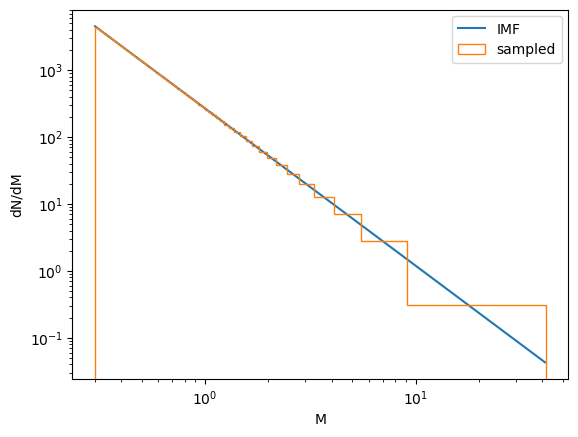

In [7]:
sp = Salpeter()
cl = make_cluster(M_res,massfunc=sp,sampling='optimal')
assert M_res-cl.sum() <= sp.mmin
make_hist(cl,sp)

Total cluster mass is 999.986 (limit was 1000)


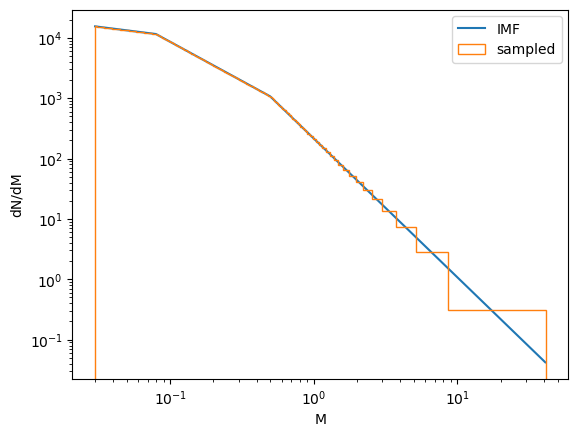

In [8]:
kr = Kroupa()
cl = make_cluster(M_res,massfunc=kr,sampling='optimal')
assert M_res-cl.sum() <= kr.mmin
make_hist(cl,kr)

Total cluster mass is 999.987 (limit was 1000)


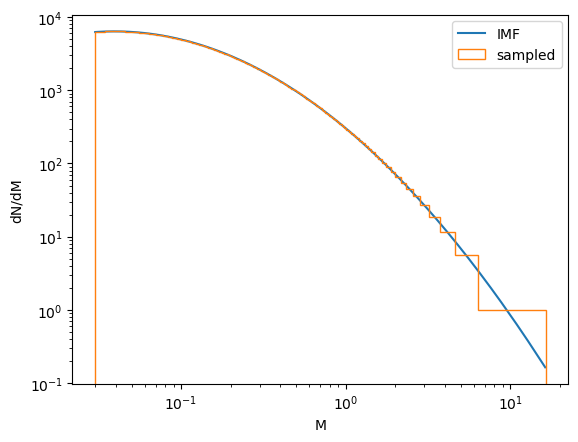

In [9]:
chl = ChabrierLogNormal(mmin=0.03)
cl = make_cluster(M_res,massfunc=chl,sampling='optimal')
assert M_res-cl.sum() <= chl.mmin
make_hist(cl,chl)

Total cluster mass is 1000.0 (limit was 1000)


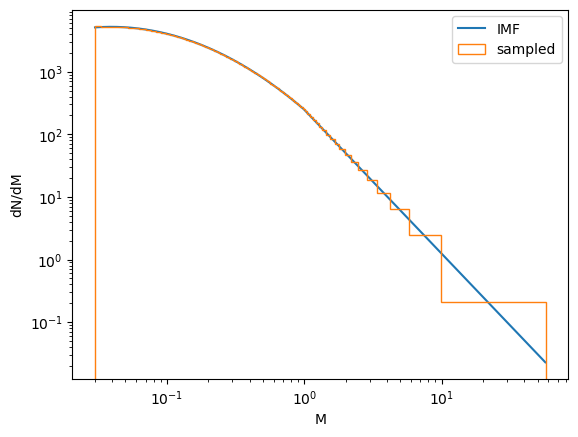

In [10]:
chp = ChabrierPowerLaw(mmin=0.03)
cl = make_cluster(M_res,massfunc=chp,sampling='optimal')
assert M_res-cl.sum() <= chp.mmin
make_hist(cl,chp)

/blue/adamginsburg/richardson.t/research/imf/imf/imf/imf.py:1016: IntegrationWarning: The maximum number of subdivisions (50) has been achieved.
  If increasing the limit yields no improvement it is advised to analyze 
  the integrand in order to determine the difficulties.  If the position of a 
  local difficulty can be determined (singularity, discontinuity) one will 
  probably gain from splitting up the interval and calling the integrator 
  on the subranges.  Perhaps a special-purpose integrator should be used.
  limit=self._quad_sub_limit, **kwargs)
/blue/adamginsburg/richardson.t/research/imf/imf/imf/imf.py:1027: IntegrationWarning: The maximum number of subdivisions (50) has been achieved.
  If increasing the limit yields no improvement it is advised to analyze 
  the integrand in order to determine the difficulties.  If the position of a 
  local difficulty can be determined (singularity, discontinuity) one will 
  probably gain from splitting up the interval and calling the 

Total cluster mass is 999.995 (limit was 1000)


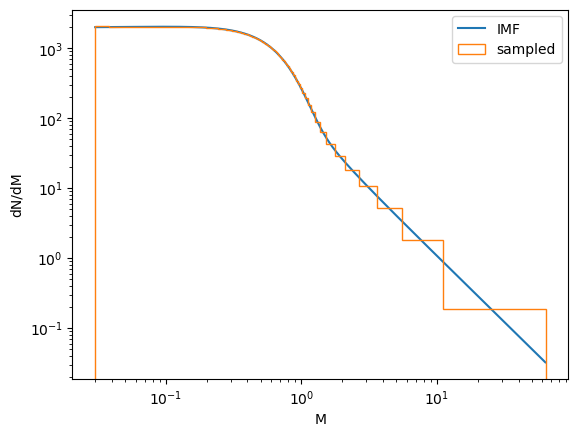

In [11]:
koc = KoenConvolvedPowerLaw(0.03,120,0.9,0.4)
cl = make_cluster(M_res,massfunc=koc,sampling='optimal')
assert M_res-cl.sum() <= koc.mmin
make_hist(cl,koc)

As mentioned above, using optimal sampling for ``KoenConvolvedPowerLaws`` can yield slightly incorrect results when interpolation does not appropriately capture the function. Optimal sampling will catch this when it occurs, stop if necessary, and return the generated cluster. The total mass should still be comparable to the expected mass, as the differences do not manifest until the low-mass end. Accuracy of the total cluster mass may be improvable by increasing the number of subdivisions permitted to [scipy.integrate.quad](https://docs.scipy.org/doc/scipy/reference/generated/scipy.integrate.quad.html) (which handles the underlying integration) as follows:

In [12]:
print(koc.quad_sub_limit)
koc.quad_sub_limit = 100
print(koc.quad_sub_limit)

50
100


Example of providing a mass function with mmin = 0 and tolerance = 0. Optimal sampling will throw a ValueError if a nonzero (or negative, or non-finite) lower limit is not provided.

Caught exception due to zero mmin and tolerance.


/blue/adamginsburg/richardson.t/research/imf/imf/imf/imf.py:541: RuntimeWarning: divide by zero encountered in log
  if not np.isfinite(np.log(mmin)):
/blue/adamginsburg/richardson.t/research/imf/imf/imf/imf.py:542: RuntimeWarning: divide by zero encountered in log
  if not np.isfinite(np.log(tolerance)):


Total cluster mass is 999.907 (limit was 1000)


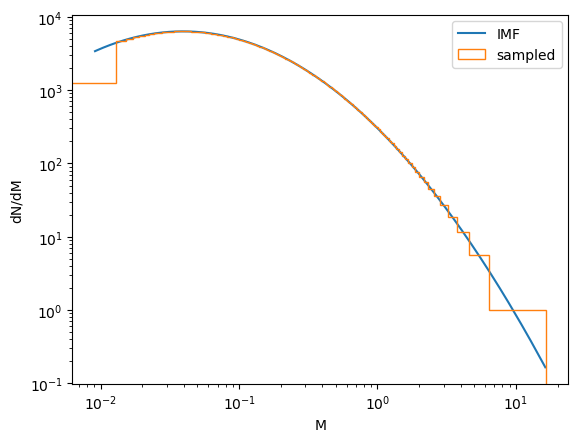

In [13]:
chl = ChabrierLogNormal()
try:
    cl = make_cluster(1e3,massfunc=chl,sampling='optimal')
except(ValueError):
    print('Caught exception due to zero mmin and tolerance.')
tolerance = 0.1
cl = make_cluster(1e3,massfunc=chl,sampling='optimal',tolerance=tolerance)
assert M_res-cl.sum() <= tolerance
make_hist(cl,chl)

Optimal sampling is a fundamentally iterative process, as the mass of each star is dependent on the previous star. As such, making a cluster requires integrating the mass function (properly normalized) from the most massive star down to the lower mass limit and adding each newly found star to the total mass. For massive clusters and standard stellar mass limits, this can take a very long time.

Total cluster mass is 99999.992 (limit was 100000)
Total time to make this cluster was 2436.0 seconds.


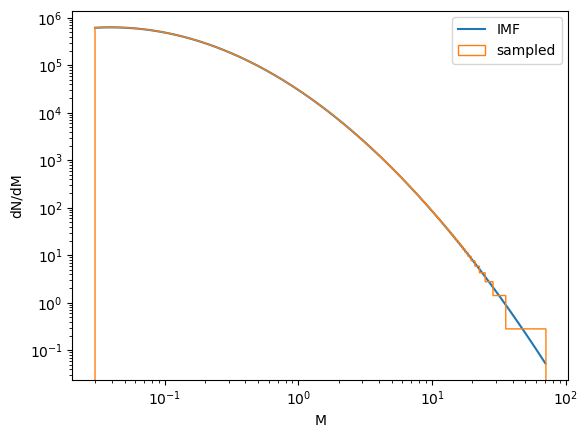

In [14]:
chl = ChabrierLogNormal(mmin=0.03,mmax=150)
t0 = perf_counter()
cl = make_cluster(M_res*100,massfunc=chl,sampling='optimal')
tot_time = perf_counter() - t0
print(f'Total time to make this cluster was {np.round(tot_time)} seconds.')
assert M_res-cl.sum() <= chl.mmin
make_hist(cl,chl)